<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/error-analysis/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import load_model
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/cs230 project/dataset/webcam amil.zip' -d dev
! unzip -q '/content/drive/My Drive/cs230 project/dataset/webcam paki.zip' -d dev

In [0]:
def get_datagen(dataset):
    return ImageDataGenerator().flow_from_directory(
              dataset,
              target_size=(48, 48),
              color_mode='grayscale',
              shuffle = True,
              class_mode='categorical',
              batch_size=32)

In [6]:
from skimage import io, transform

X_dev_gen    = get_datagen('/content/dev')

X_dev = np.zeros((len(X_dev_gen.filepaths), 48, 48, 1))
Y_dev = np.zeros((len(X_dev_gen.filepaths), 7))
for i in range(0,len(X_dev_gen.filepaths)):
  x = io.imread(X_dev_gen.filepaths[i], as_gray=True)
  X_dev[i,:] = transform.resize(x, (48,48,1))
  Y_dev[i,X_dev_gen.classes[i]] = 1

Found 204 images belonging to 7 classes.


In [0]:
model = load_model('/content/drive/My Drive/cs230 project/models/webcam-SGD_LR_0.01000-EPOCHS_100-BS_128-DROPOUT_0.35test_acc_0.273.h5')

In [0]:
# TODO: subtract probabilities?
y_pred_probs = model.predict(X_dev)
y_pred = y_pred_probs.argmax(axis=1)
y_true = Y_dev.argmax(axis=1)

In [16]:
incorrect = np.count_nonzero(y_pred-y_true)
print("Accuracy on dev images: {:.2%}".format(1.0 - incorrect/len(y_true)))

Accuracy on dev images: 65.69%


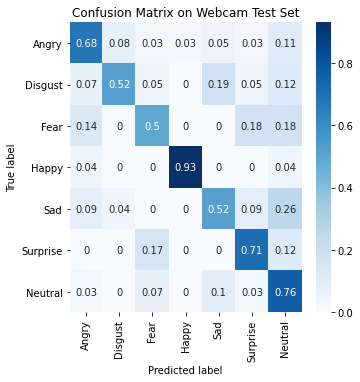

In [17]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Webcam Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [0]:
# angry: many images classified like this
# disgust: not many images classified disgust
# fear: not many images classified fear
# happy is grea, high precision
# sad: many disgust predicted sad
# surprise: some fears are surprise
# neutral: low precision, many other emotions classified as neutral (sad)

In [0]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

In [24]:
for i in range(0, len(y_pred)):
  if emotions[y_true[i]] == 'Happy' and emotions[y_pred[i]] == 'Happy':
      print(i)

102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
126
127


3 happy/happy-255248-0015.png
[0.07 0.   0.02 0.71 0.13 0.   0.06]


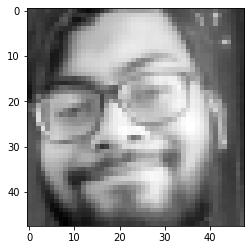

<Figure size 432x288 with 0 Axes>

In [25]:
i=102

print(X_dev_gen.filenames[i])
plt.imshow(X_dev[i].reshape(48,48),cmap='gray')
plt.figure()
print(y_pred_probs[i].round(2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

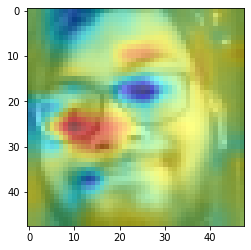

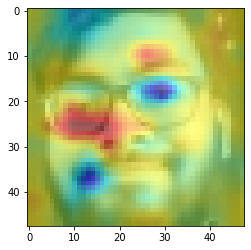

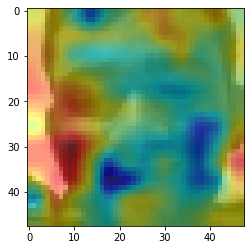

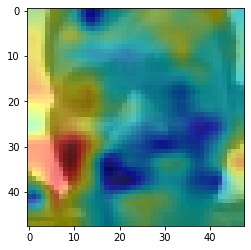

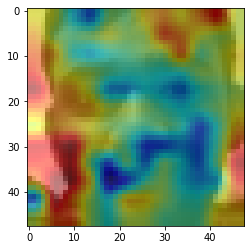

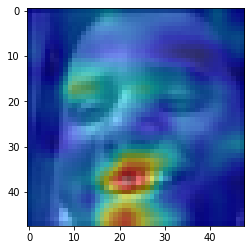

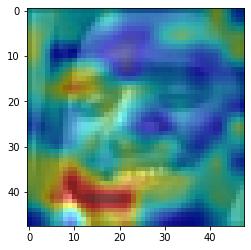

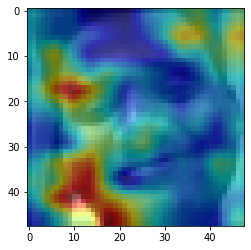

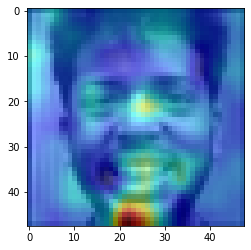

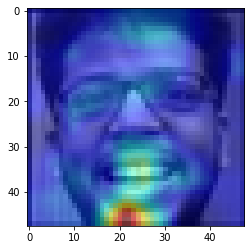

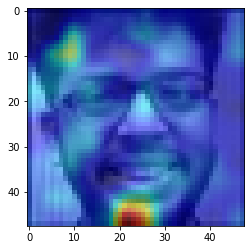

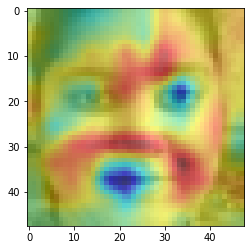

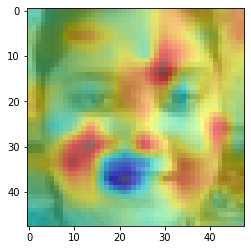

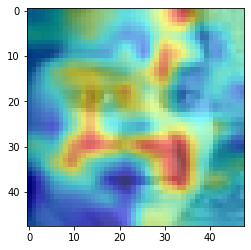

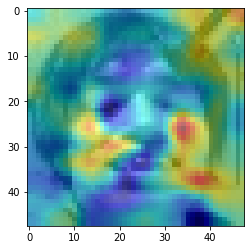

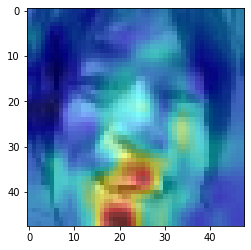

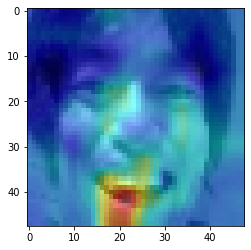

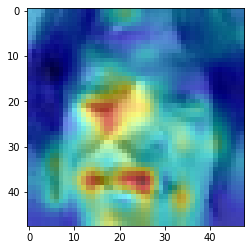

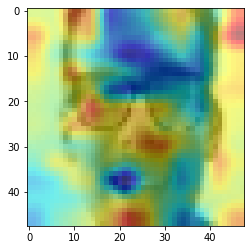

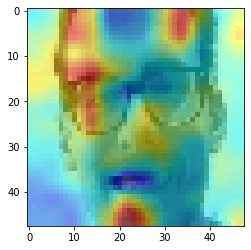

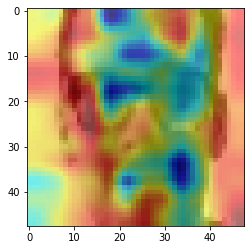

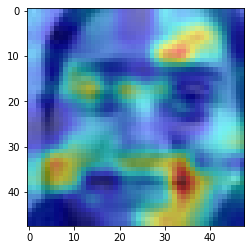

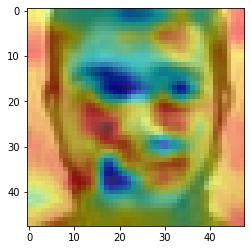

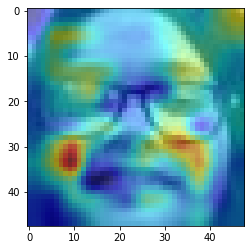

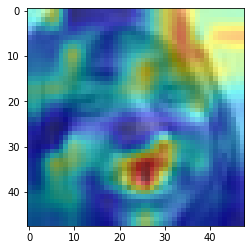

<Figure size 432x288 with 0 Axes>

In [43]:
import cv2

for i in range(0, len(y_pred)):
  if emotions[y_true[i]] == 'Happy' and emotions[y_pred[i]] == 'Happy':
    single_example = X_dev[i]
    label = 3

    LAST_LAYER = "conv3"
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAST_LAYER).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(single_example.reshape(1, 48, 48, 1 ))
        loss = preds[:,label]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.ones(output.shape[0: 2], dtype = np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = cv2.resize(cam.numpy(), (48, 48))
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    plt.imshow(single_example.reshape(48,48),cmap='gray')
    plt.imshow(cam,cmap='gray', alpha=0.5)
    plt.figure()

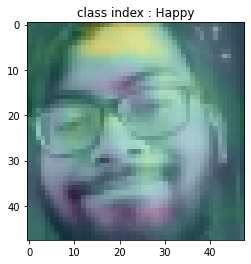

In [63]:
y_dev = Y_dev.argmax(axis=1)

# Select an image to show the saliency map on
indx=102
plt.title(label = "class index : {}".format(emotions[y_dev[indx]]))
plt.imshow(X_dev[indx].reshape(48,48),cmap='gray')
target_image = X_dev[indx].reshape(1,48,48,1)

weights = model.weights[-2][:,y_dev[indx]]
output_conv4_model = Model(inputs=model.input, outputs=model.get_layer("conv3").output)
layer_feature_maps = output_conv4_model.predict(target_image)

#TODO: vectorize
cam = 0
for k in range(layer_feature_maps.shape[-1]): 
     cam += weights[k]*layer_feature_maps[:,:,:,k]


cam = np.reshape(cam,[12,12,1])
#plt.imshow(np.resize(cam,(48,48)))
cam_resized= tf.image.resize(cam,[48,48])
plt.imshow(target_image.reshape(48,48),cmap='gray')
plt.imshow(cam_resized.numpy().reshape(48,48),alpha=0.4)

In [80]:
from tensorflow.keras import backend as K
from tensorflow.keras import Model

indx=102

# # reshape individual image 
single_example = X_dev[indx].reshape(1,48,48,1)

# four lines are needed to generate a function that computes the gradients 
# remember that you need to specific which class the image belongs to. 
# this is specified in the example_model_output. 
input_tensors = [model.input]
example_model_output = model.output[0][y_dev[indx]]
gradients = model.optimizer.get_gradients(example_model_output, model.input)
compute_gradients = K.function(inputs = input_tensors, outputs = gradients)

gradient_fun  = Model(inputs= model.input, outputs=gradients)
gradients_value = gradient_fun(single_example.astype("float32"))

# plot the gradient values 
plt.figure()
plt.imshow(single_example.reshape(48,48))
plt.show()
plt.figure()
plt.imshow(gradients_value.numpy().reshape(48,48))
plt.show()

InvalidArgumentError: ignored